# XGBoost tuning
Goal: tune an XGBoost model in this notebook with the cleaned samples.
***

## Table of Contents 

1. [Intuition Behind Tuning Approach](#1.-Intuition-Behind-Tuning-Approach)
2. [Intuition Behind Evaluation Metrics](#2.-Intuition-Behind-Evaluation-Metrics)
3. [Load Data](#3.-Load-Data)
4. [Define Functions](#4.-Define-Functions)
5. [Building a Baseline Model](#5.-Building-a-Baseline-Model)
6. [Equalize Class Imbalance](#6.-Equalize-Class-Imbalance)
7. [Control Overfitting](#7.-Control-Overfitting)
<br>7.1 [Parameters max_depth, min_child_weight, and gamma](#7.1-Parameters-max_depth,-min_child_weight,-and-gamma)
<br>7.2 [Parameters subsample and colsample_bytree](#7.2Parameters-subsample-and-colsample_bytree)
<br>7.3 [Parameters learning_rate and n_estimators](#7.3-Parameters-learning_rate-and-n_estimators)
8. [Optimal Parameters](#8.-Optimal-Parameters)
9. [Iteration Comparision](#9.-Iteration-Comparisons)
10. [Final Model](#10.-Final-Model)
11. [Additional Reference](#11.-Additional-Reference)

## 1. Intuition Behind Tuning Approach

1. **Build a baseline model** to measure efficacy of parameter tuning for evaluation metric improvements.
2. **Equalize the class imbalance** to get a more reliable evaluation of model performance.
3. **Control overfitting** by tuning model complexity and making training data robust to noise.

## 2. Intuition Behind Evaluation Metrics
Given our imbalanced classification problem where the positive class, "no-churn", greatly outnumbers the negative class, "churn", accuracy is not a good measure for assessing model performance because the model will biasedly predict more records as the majority class and convey a misleading evaluation.

Precision and recall are more appropriate metrics to use since they don't make use of the overwhelming, negative class ("no-churn") predictions and instead focus on identifying the positive "churn" cases. For our model evaluation, we will analyze precision, recall, f1-score, AUCPR (area under precision-recall curve), and AUC (area under ROC curve).

Given our particular business scenario, we will closely analyze the **recall** metric. Recall evaluates the ability of a model to find all the relevant cases within a dataset; it is the number of *true positives* divided by the sum of *true positives* and *false negatives*. In the scope of this project, true positives are correctly identified "churn" customers, and **false negatives are individuals the model labels as "retained" who actually "churned"**. 

A false negative is most problematic in our scenario because we misclassify a group of churned customers and miss an opportunity to market towards a niche group in a retention program that is, on average, a fraction of the cost of an acquisition program. By minimizing the number of false negatives, we can maximize our recall value and market towards the largest group of customers predicted to churn.

We will also take **precision** into consideration when evaluating performance, which is the model's ability to identify the relevant "churn" data points. A model with high recall and mid-to-low precision will account for a high percentage of correctly predicted "churn" customers and a low percentage of retained customers that were misclassified as "churned".

The main tradeoff here are the additional marketing dollars spent on retained customers that should ideally be spent on customers likely to churn - this, however, isn't entirely undesirable since the marketing dollars allocated towards "retained" customers will add to their longevity with the company.
***

## 3. Load Data

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Import cleaned datasets
df = pd.read_csv('data/cleaned_data/og_cleaned_samples.csv', index_col='customerID')
df_cat_encoded = pd.read_csv('data/cleaned_data/num_cleaned_samples.csv', index_col='customerID')

# Create features and target arrays
X = df_cat_encoded.drop(['Churn_Yes', 'gender_Male'], axis=1).values
y = df_cat_encoded.Churn_Yes.values

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

To create our features array, we drop the Churn feature since that is our target variable and we are trying to predict its labels. From our EDA, we determined that a customer's gender likely has no effect on their propensity to churn since it wasn't strongly correlated with other features and had no notable differences in churn rates between genders.
***

## 4. Define Functions

In [2]:
from sklearn.metrics import auc, roc_curve, precision_recall_curve, average_precision_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

# Function return the model's AUCPR and AUC scores at the iteration 
# with the highest AUC score. The AUCPR can still be higher at an 
# earlier or later iteration, but the function will return the AUCPR
# score at the iteration with the highest AUC score. We will be using
# AUC as the primary evaluation metric b/c we are going to balance the 
# classes later.
def logloss_aucpr_auc(clf_name, evals_result_dict):
    """Compute the AUCPR and AUC at the model's 
    best iteration, using the AUC as the early
    stopping metric."""
    eval_mtrs = [{'logloss': i['logloss'][clf_name.best_iteration], 'aucpr': i['aucpr'][clf_name.best_iteration], 'auc': i['auc'][clf_name.best_iteration]} for i in evals_result_dict.values()]
    logloss_mtr = eval_mtrs[0]['logloss']
    aucpr_mtr = eval_mtrs[0]['aucpr']
    auc_mtr = eval_mtrs[0]['auc']
    print('AUC:       {:.3f}'.format(auc_mtr))
    print('AUCPR:     {:.3f}'.format(aucpr_mtr))
    print('Logloss:   {:.3f}'.format(logloss_mtr))

# Define function to calculate classification report metrics.
# (calculating individually to draw easier comparisons)
def class_metrics(y_test, binary_preds):
    """Calculation classification metrics."""
    print('Precision: {0:.3f}'.format(precision_score(y_test, binary_preds)))
    print('Recall:    {0:.3f}'.format(recall_score(y_test, binary_preds)))
    print('f1-score:  {0:.3f}'.format(f1_score(y_test, binary_preds)))

# Define function to plot ROC curve.     
def plot_roc(clf_name):
    """Plot the ROC curve for a given classifier."""
    # Calculate the fpr and tpr for all thresholds of the classification
    probs = clf_name.predict_proba(X_test)
    preds = probs[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(7, 7))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.3f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# Define function to plot PR curve.
def plot_pr(clf_name):
    """Plot the precision-recall curve for a given classifier."""
    # Calculate the precision and recall for all thresholds of the classification
    probs = clf_name.predict_proba(X_test)
    preds = probs[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    average_precision = average_precision_score(y_test, preds)

    # Plot PR curve
    plt.figure(figsize=(7, 7))
    plt.title('Precision-Recall Curve')
    plt.plot(recall, precision, 'b', label='AUCPR = %0.3f' % average_precision)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0.5, 0.5],'r--')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.show()

# Define function to plot ROC and PR curve.
def plot_roc_pr(clf_name):
    """Plot the ROC and PR-curve for a given classifier."""
    plt.figure(figsize=(14, 7))
    # Plot ROC
    plt.subplot(121)
    probs = clf_name.predict_proba(X_test)
    preds = probs[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.3f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    
    # Plot PR curve
    plt.subplot(122)
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    average_precision = average_precision_score(y_test, preds)
    plt.title('Precision-Recall Curve')
    plt.plot(recall, precision, 'b', label='AUCPR = %0.3f' % average_precision)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0.5, 0.5],'r--')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.show()

### 5. Building a Baseline Model
In order to get an idea of the range of precision and recall we would like our model to surpass, we are going to build a baseline model and save its score for later. This score is what we can achieve with no tuning. 

In [3]:
import xgboost as xgb

# Define baseline parameters
params_base = {
    'verbosity': 0,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'seed': 42
}

# Instantiate an XGBoost classifier
clf = xgb.XGBClassifier(**params_base)

# Fit classifier
clf.fit(
    X_train, 
    y_train,
    eval_set=[(X_test, y_test)],
    eval_metric=['logloss', 'aucpr', 'auc'],          # Pass in the eval_metric in this order!
    early_stopping_rounds=10,
    verbose=False
)
# Store evaluation metrics in a dict
evals_result = clf.evals_result()

# Print metrics at the model's best iteration
# (you can verify that the AUC is correct by running: clf.best_score)
print('AUC used as primary evaluation metric for early stopping.')
print('AUCPR output at best AUC score shown below.')
print('Best iteration at {} rounds.'.format(clf.best_iteration))
logloss_aucpr_auc(clf, evals_result)

# The following returns continuous values for the 
# predictions that correspond to the binary predictions:
# probs = clf.predict_proba(X_test)
# preds = probs[:, 1]
# ----
# The following returns binary values for the predictions
# Must use binary predictions as input for the following:
# precision_score, recall_score, f1_score, confusion_matrix, classification_report
ypred = clf.predict(X_test, ntree_limit=clf.best_ntree_limit)
class_metrics(y_test, ypred)

AUC used as primary evaluation metric for early stopping.
AUCPR output at best AUC score shown below.
Best iteration at 40 rounds.
AUC:       0.841
AUCPR:     0.646
Logloss:   0.422
Precision: 0.656
Recall:    0.488
f1-score:  0.560


With the model's parameters set to their default values and no tuning, we get the baseline metric scores listed above. Let's tweak a few parameters and potentially increase our baseline scores.

### 6. Equalize Class Imbalance
Most notably in this step, we apply more weight to the positive "churn" class. We apply the ratio of negative-to-positive classes to the positive class.

In [4]:
# Load data into DMatrices (optimized for xgb algorithm)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Balance the positive and negative weights and assign it to the scale_pos_weight parameter
train_labels = dtrain.get_label()
ratio = float(np.sum(train_labels == 0)) / np.sum(train_labels == 1)
print('Value for scale_pos_weight: {:.2f}'.format(ratio))

Value for scale_pos_weight: 2.76


According to the XGBoost documentation, setting the **scale_pos_weight** parameter to the ratio of negative to positive classes will help equalize the class imbalance and require AUC for evaluation. It's acceptable to now use AUC for model evaluation since the ROC curve is less weighted towards the true negatives thereby providing a less biased representation of the model's performance.

In [5]:
# Set hyperparameters
params = {
    'max_depth':        5,        # tweaked
    'min_child_weight': 10,       # tweaked
    'gamma':            1,        # tweaked
    'subsample':        1,        
    'colsample_bytree': 1,        
    'learning_rate':    0.3,      # tweaked
    'n_estimators':     500,      # tweaked
    'scale_pos_weight': 2.76,     # tweaked
    'verbosity':        0,
    'objective':       'binary:logistic',
    'eval_metric':     ['aucpr', 'auc'],          
    'seed':             42
}

# Instantiate classifier
clf1 = xgb.XGBClassifier(**params)

# Fit classifier
clf1.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    eval_metric=['logloss', 'aucpr', 'auc'],
    early_stopping_rounds=10,
    verbose=False
)
# Store metrics in a dict
evals_result1 = clf1.evals_result()

# Print metrics at the model's best iteration
print('AUC used as primary evaluation metric for early stopping.')
print('AUCPR output at best AUC score shown below.')
print('Best iteration at {} rounds.'.format(clf1.best_iteration))
logloss_aucpr_auc(clf1, evals_result1)

# Make predictions
ypred1 = clf1.predict(X_test, ntree_limit=clf1.best_ntree_limit)
class_metrics(y_test, ypred1)

AUC used as primary evaluation metric for early stopping.
AUCPR output at best AUC score shown below.
Best iteration at 7 rounds.
AUC:       0.842
AUCPR:     0.644
Logloss:   0.494
Precision: 0.519
Recall:    0.799
f1-score:  0.629


The parameter tweaks improved our model's performance across all metrics, especially for recall. Let's compare the baseline model to the equalized model and further analyze the changes.

In [6]:
print('Baseline model:')
logloss_aucpr_auc(clf, evals_result)
class_metrics(y_test, ypred)

print('\nEqualized model:')
logloss_aucpr_auc(clf1, evals_result1)
class_metrics(y_test, ypred1)

Baseline model:
AUC:       0.841
AUCPR:     0.646
Logloss:   0.422
Precision: 0.656
Recall:    0.488
f1-score:  0.560

Equalized model:
AUC:       0.842
AUCPR:     0.644
Logloss:   0.494
Precision: 0.519
Recall:    0.799
f1-score:  0.629


Tweaking only a few parameters increased the model's overall performance at the expense of its precision - mainly attributed to reweighting the positive class. 

The baseline model classified imbalanced samples - where the negative class was significantly larger than the positive class. The second, minimally-tuned model classified the *same* samples with about 3 times more weight on the positive class to equalize the imbalance and unbiasedly predict data points. 

As a result, the tuned classifier's ability to find all positive samples increases - represented by an increase in recall - at the expense of labeling more negative samples as positive - represented by a decrease in precision. The tradeoff of a lower precision isn't entirely undesireable here since the f1-score increased - which is the harmonic mean of precision and recall. The f1-score gives equal weight to both measures and is useful to create a classification model with an optimal balance of precision and recall. 

We are interested in a higher recall score, which may not necessarily be the optimal balance of precision and recall - but given the increase in recall and f1-score with tuning, we know that finding optimal parameters may increase both scores and increase our model's predictive power. Let's use cross validation and gridsearch to find the optimal parameters for our model. 

## 7. Control Overfitting
### 7.1 Parameters max_depth, min_child_weight, and gamma
These parameters add contraints on the architecture of the trees and directly control complexity to reduce overfitting. We tune them together to find a good trade-off between model bias and variance. According to the XGBoost documentation, after balancing the class weights, we use AUC for evaluation - we've already been using AUC for evaluation so far with the XGBoost classifiers, but we'll now use it as our scoring metric when performing the gridsearch. 

In [7]:
from sklearn.model_selection import GridSearchCV
import time

# Parameters to tune
params_grid = {
    'max_depth':        np.arange(3, 11, 1),
    'min_child_weight': np.arange(4, 16, 1),
    'gamma':            np.arange(1, 6, 1)
}

# Set fixed parameters (we'll tune these params in the following sections)
params = {
    'subsample':        1,        
    'colsample_bytree': 1,        
    'learning_rate':    0.3,      
    'n_estimators':     500,
    'scale_pos_weight': 2.76,        
    'verbosity':        0,
    'objective':        'binary:logistic',
    'eval_metric':      ['logloss', 'aucpr', 'auc'],     
    'seed':             42
}

# Perform grid search to find optimal tuning parameters
bst_grid = GridSearchCV(
    estimator=xgb.XGBClassifier(**params),
    param_grid=params_grid,
    scoring='roc_auc',
    cv=3,
    verbose=0   
)

# Fit the model
%time bst_grid.fit(X_train, y_train)

print('Best AUC score: {0:.3f}'.format(bst_grid.best_score_))
print('Best parameters:')
for key, val in bst_grid.best_params_.items():
    print('\t{}: {}'.format(key, val))

CPU times: user 1h 9min 25s, sys: 27.8 s, total: 1h 9min 53s
Wall time: 1h 11min 4s
Best AUC score: 0.846
Best parameters:
	gamma: 5
	max_depth: 3
	min_child_weight: 13


After tuning max_depth, min_child_weight, and gamma, we get an **improved AUC score of 0.846** - an improvement of 0.007 - with the following tested optimal parameters:
* **max_depth: 3**
* **min_child_weight: 13**
* **gamma: 5**

Let's update our tested parameters with the aforementioned values and tune another set of parameters that control overfitting.

*(The run time for testing these parameters was 1h 11min)*

### 7.2 Parameters subsample and colsample_bytree
These parameters control the sampling of the dataset that is done at each boosting round and add randomness to make training robust to noise to control overfitting. 

In [8]:
# Parameters to tune
params_grid = {
    'subsample':        np.arange(.1, 1.1, .1),        
    'colsample_bytree': np.arange(.1, 1.1, .1)
}

# Set fixed parameters
params = {
    'max_depth':        3,
    'min_child_weight': 13,
    'gamma':            5,     
    'learning_rate':    0.3,      
    'n_estimators':     500,
    'scale_pos_weight': 2.76,        
    'verbosity':        0,
    'objective':        'binary:logistic',
    'eval_metric':      ['logloss', 'aucpr', 'auc'],     
    'seed':             42
}

# Perform grid search to find optimal tuning parameters
bst1_grid = GridSearchCV(
    estimator=xgb.XGBClassifier(**params),
    param_grid=params_grid,
    scoring='roc_auc',
    cv=3,
    verbose=0   
)

# Fit the model
%time bst1_grid.fit(X_train, y_train)

print('Best AUC score: {0:.3f}'.format(bst1_grid.best_score_))
print('Best parameters:')
for key, val in bst1_grid.best_params_.items():
    print('\t{}: {}'.format(key, val))

CPU times: user 7min 38s, sys: 5.77 s, total: 7min 43s
Wall time: 7min 55s
Best AUC score: 0.848
Best parameters:
	colsample_bytree: 0.1
	subsample: 1.0


After tuning subsample and colsample_bytree, we get an **improved AUC score of 0.848** - an improvement of 0.002 - with the following tested optimal parameters:
* **subsample: 1.0**
* **colsample_bytree: 0.1**

Let's update our tested parameters with the aforementioned values and tune another set of parameters that control overfitting.

*(The run time for testing these parameters was 8min)*

### 7.3 Parameters learning_rate and n_estimators
The learning_rate parameter is used shrink the feature weights after each boosting round; it defines the amount of "correction" we make at each step to prevent overfitting. In practice, having a lower learning rate makes our model more robust to overfitting, thus, the lower the learning_rate the better. However, with a lower learning rate we need more boosting rounds - which corresponds to more trees (n_estimators). Both of these parameters add randomness to make training robust to noise to control overfitting.

We will optimize learning_rate and n_estimators twice. In the first iteration, we'll test relatively larger values in a wide interval to capture our first optimal value. During the second iteration, we'll use the previously identified values as the median for a new range of values at a smaller interval to determine a more precise optimal parameter.

#### Iteration 1:

In [9]:
# Parameters to tune
params_grid = {
    'learning_rate':    [0.005, 0.05, 0.1, 0.2, 0.3, 0.4],      
    'n_estimators':     [100, 300, 500, 700, 900],
}

# Set fixed parameters
params = {
    'max_depth':        3,
    'min_child_weight': 13,
    'gamma':            5,
    'subsample':        1,
    'colsample_bytree': 0.1,
    'scale_pos_weight': 2.76,        
    'verbosity':        0,
    'objective':        'binary:logistic',
    'eval_metric':      ['logloss', 'aucpr', 'auc'],     
    'seed':             42
}


bst2_grid = GridSearchCV(
    estimator=xgb.XGBClassifier(**params),
    param_grid=params_grid,
    scoring='roc_auc',      
    cv=3,
    verbose=0
)

# Fit the model
%time bst2_grid.fit(X_train, y_train)

print('Best AUC score: {0:.3f}'.format(bst2_grid.best_score_))
print('Best parameters:')
for key, val in bst2_grid.best_params_.items():
    print('\t{}: {}'.format(key, val))

CPU times: user 1min 35s, sys: 1.29 s, total: 1min 36s
Wall time: 1min 39s
Best AUC score: 0.851
Best parameters:
	learning_rate: 0.05
	n_estimators: 700


After our first iteration of tuning the learning_rate and n_estimators, we get an **improved AUC score of 0.851** - an improvement of 0.003 - with the following tested optimal parameters:
* **learning_rate: 0.05**
* **n_estimators: 700**

Let's run our second tuning iteration for the same parameters - using these identified  parameter values as medians for a smaller interval of testing values.

*(The run time for testing these parameters was 1min)*

#### Iteration 2:

In [10]:
# Parameters to tune
params_grid = {
    'learning_rate':    np.linspace(0.005, 0.2, 20),      
    'n_estimators':     np.arange(500, 900, 20)
}

# Set fixed parameters
params = {
    'max_depth':        3,
    'min_child_weight': 13,
    'gamma':            5,
    'subsample':        1,
    'colsample_bytree': 0.1,
    'scale_pos_weight': 2.76,        
    'verbosity':        0,
    'objective':        'binary:logistic',
    'eval_metric':      ['logloss', 'aucpr', 'auc'],     
    'seed':             42
}

bst3_grid = GridSearchCV(
    estimator=xgb.XGBClassifier(**params),
    param_grid=params_grid,
    scoring='roc_auc',      
    cv=3,
    verbose=0
)

# Fit the model
%time bst3_grid.fit(X_train, y_train)

print('Best AUC score: {0:.3f}'.format(bst3_grid.best_score_))
print('Best parameters:')
for key, val in bst3_grid.best_params_.items():
    print('\t{}: {}'.format(key, val))

CPU times: user 27min 56s, sys: 20.2 s, total: 28min 16s
Wall time: 28min 57s
Best AUC score: 0.851
Best parameters:
	learning_rate: 0.025526315789473685
	n_estimators: 860


The (rounded) AUC score does not change after optimizing the learning_rate and n_estimators with the following optimal parameters:
* **learning_rate: 0.026**
* **n_estimators: 860**

Let's update our tested parameters with the aforementioned values.

*(The run time for testing these parameters was 29min)*

### 8. Optimal Parameters
Let's train a model with our optimal parameters and see how it does on our test set.

In [29]:
# Optimal params
params = {
    'max_depth':        3,
    'min_child_weight': 13,
    'gamma':            5,
    'subsample':        1,        
    'colsample_bytree': 0.1,        
    'learning_rate':    0.026,      
    'n_estimators':     860,
    'scale_pos_weight': 2.76,        
    'verbosity':        0,
    'objective':        'binary:logistic',
    'eval_metric':      ['logloss', 'aucpr', 'auc'],
    'seed':             42
}

# Instantiate an XGBoost classifier
clf_final = xgb.XGBClassifier(**params)

# Fit classifier
clf_final.fit(
    X_train, 
    y_train,
    eval_set=[(X_test, y_test)],
    eval_metric=['logloss', 'aucpr', 'auc'],          
    early_stopping_rounds=10,
    verbose=False
)
# Store evaluation metrics in a dict
evals_result_final = clf_final.evals_result()

# Print metrics at the model's best iteration
# (you can verify that the AUC is correct by running: clf.best_score)
print('AUC used as primary evaluation metric for early stopping.')
print('AUCPR output at best AUC score shown below.')
print('Best iteration at {} rounds.'.format(clf_final.best_iteration))
logloss_aucpr_auc(clf_final, evals_result_final)

# Make predictions
ypred_final = clf_final.predict(X_test, ntree_limit=clf_final.best_ntree_limit)
class_metrics(y_test, ypred_final)

AUC used as primary evaluation metric for early stopping.
AUCPR output at best AUC score shown below.
Best iteration at 36 rounds.
AUC:       0.837
AUCPR:     0.640
Logloss:   0.606
Precision: 0.499
Recall:    0.788
f1-score:  0.611


* Fitting a model with XGBoost's .fit() method yields different evaluation metrics than GridSearch scoring. 
* So let's fit a model at each iteration with the optimal parameters found at the end of each iteration to identify our best performing parameters. 
* After fitting classifiers, let's plot them and compare the evaluation metrics at the end of each iteration to visualize tuning efficacy. 
***

## 9. Iteration Comparisons
1. Fit models at each iteration and document metrics in a dataframe.
2. Plot the dataframe in a lineplot to show changes at each iteration. 
3. Choose the best iteration and use its parameters for final model. 
4. Provide explanation for iteration selection.

In [19]:
def fit_model(clf_name):
    """Fit a classifier."""
    clf_name.fit(
        X_train, 
        y_train,
        eval_set=[(X_test, y_test)],
        eval_metric=['logloss', 'aucpr', 'auc'],          
        early_stopping_rounds=10,
        verbose=False
    )

### Iteration 0 (baseline model)
Default parameters and a seed

In [25]:
print('Baseline model:')
print('Best iteration at {} rounds.'.format(clf.best_iteration))
logloss_aucpr_auc(clf, evals_result)
class_metrics(y_test, ypred)

Baseline model:
Best iteration at 40 rounds.
AUC:       0.841
AUCPR:     0.646
Logloss:   0.422
Precision: 0.656
Recall:    0.488
f1-score:  0.560


### Iteration 1 (equalize classes)
Parameter scale_pos_weight

In [26]:
print('Equalized model:')
print('Best iteration at {} rounds.'.format(clf1.best_iteration))
logloss_aucpr_auc(clf1, evals_result1)
class_metrics(y_test, ypred1)

Equalized model:
Best iteration at 7 rounds.
AUC:       0.842
AUCPR:     0.644
Logloss:   0.494
Precision: 0.519
Recall:    0.799
f1-score:  0.629


### Iteration 2 (control overfitting 1)
Parameters max_depth, min_child_weight, and gamma

In [21]:
# Parameters at the end of this iteration
params = {
    'max_depth':        3,
    'min_child_weight': 13,
    'gamma':            5,
    'subsample':        1,        
    'colsample_bytree': 1,        
    'learning_rate':    0.3,      
    'n_estimators':     500,
    'scale_pos_weight': 2.76,        
    'verbosity':        0,
    'objective':        'binary:logistic',
    'eval_metric':      ['logloss', 'aucpr', 'auc'],     
    'seed':             42
}

# Instantiate classifier
clf_iter2 = xgb.XGBClassifier(**params)

# Fit classifier
fit_model(clf_iter2)

# Store eval metrics in a dict
evals_iter2 = clf_iter2.evals_result()

# Print metrics
print('Best iteration at {} rounds.'.format(clf_iter2.best_iteration))
logloss_aucpr_auc(clf_iter2, evals_iter2)

# Make predictions
ypred_iter2 = clf_iter2.predict(X_test, ntree_limit=clf_iter2.best_ntree_limit)
class_metrics(y_test, ypred_iter2)

Best iteration at 16 rounds.
AUC:       0.839
AUCPR:     0.647
Logloss:   0.496
Precision: 0.498
Recall:    0.813
f1-score:  0.617


### Iteration 3 (control overfitting 2)
Parameters subsample and colsample_bytree

In [22]:
# Parameters at the end of this iteration
params = {
    'max_depth':        3,
    'min_child_weight': 13,
    'gamma':            5,
    'subsample':        1,        
    'colsample_bytree': 0.1,        
    'learning_rate':    0.3,      
    'n_estimators':     500,
    'scale_pos_weight': 2.76,        
    'verbosity':        0,
    'objective':        'binary:logistic',
    'eval_metric':      ['logloss', 'aucpr', 'auc'],     
    'seed':             42
}

# Instantiate classifier
clf_iter3 = xgb.XGBClassifier(**params)

# Fit classifier
fit_model(clf_iter3)

# Store eval metrics in a dict
evals_iter3 = clf_iter3.evals_result()

# Print metrics
print('Best iteration at {} rounds.'.format(clf_iter3.best_iteration))
logloss_aucpr_auc(clf_iter3, evals_iter3)

# Make predictions
ypred_iter3 = clf_iter3.predict(X_test, ntree_limit=clf_iter3.best_ntree_limit)
class_metrics(y_test, ypred_iter3)

Best iteration at 67 rounds.
AUC:       0.840
AUCPR:     0.648
Logloss:   0.495
Precision: 0.499
Recall:    0.797
f1-score:  0.614


### Iteration 4 (control overfitting iter. 1)
Parameters learning_rate and n_estimators (Iteration 1)

In [23]:
# Parameters at the end of this iteration
params = {
    'max_depth':        3,
    'min_child_weight': 13,
    'gamma':            5,
    'subsample':        1,        
    'colsample_bytree': 0.1,        
    'learning_rate':    0.05,      
    'n_estimators':     700,
    'scale_pos_weight': 2.76,        
    'verbosity':        0,
    'objective':        'binary:logistic',
    'eval_metric':      ['logloss', 'aucpr', 'auc'],     
    'seed':             42
}

# Instantiate classifier
clf_iter4 = xgb.XGBClassifier(**params)

# Fit classifier
fit_model(clf_iter4)

# Store eval metrics in a dict
evals_iter4 = clf_iter4.evals_result()

# Print metrics
print('Best iteration at {} rounds.'.format(clf_iter4.best_iteration))
logloss_aucpr_auc(clf_iter4, evals_iter4)

# Make predictions
ypred_iter4 = clf_iter4.predict(X_test, ntree_limit=clf_iter4.best_ntree_limit)
class_metrics(y_test, ypred_iter4)

Best iteration at 36 rounds.
AUC:       0.838
AUCPR:     0.641
Logloss:   0.562
Precision: 0.500
Recall:    0.779
f1-score:  0.609


### Iteration 5 (control overfitting iter. 2)
Final Model
<br>Parameters learning_rate and n_estimators (Iteration 2)

In [30]:
print('Final model:')
print('Best iteration at {} rounds.'.format(clf_final.best_iteration))
logloss_aucpr_auc(clf_final, evals_result_final)
class_metrics(y_test, ypred_final)

Final model:
Best iteration at 36 rounds.
AUC:       0.837
AUCPR:     0.640
Logloss:   0.606
Precision: 0.499
Recall:    0.788
f1-score:  0.611


Let's make a dataframe of the results to plot tuning efficacy at each iteration.

In [141]:
iter0 = [0.841, 0.646, 0.422, 0.656, 0.488, 0.56]
iter1 = [0.842, 0.644, 0.494, 0.519, 0.799, 0.629]
iter2 = [0.839, 0.647, 0.496, 0.498, 0.813, 0.617]
iter3 = [0.840, 0.648, 0.495, 0.499, 0.797, 0.614]
iter4 = [0.838, 0.641, 0.562, 0.500, 0.779, 0.609]
iter5 = [0.837, 0.640, 0.606, 0.499, 0.788, 0.611]

df_iters = pd.DataFrame(
    np.array([iter0, iter1, iter2, iter3, iter4, iter5]),
    columns=['AUC', 'AUCPR', 'Logloss' , 'Precision', 'Recall', 'F1_score']
)
df_iters

,AUC,AUCPR,Logloss,Precision,Recall,F1_score
0,0.841,0.646,0.422,0.656,0.488,0.560
1,0.842,0.644,0.494,0.519,0.799,0.629
2,0.839,0.647,0.496,0.498,0.813,0.617
3,0.840,0.648,0.495,0.499,0.797,0.614
4,0.838,0.641,0.562,0.500,0.779,0.609
5,0.837,0.640,0.606,0.499,0.788,0.611


* The dataframe index represents each iteration and the columns represent the evaluation metrics. 
* Let's plot the dataframe to visualize changes in evaluation metrics after each iteration. 

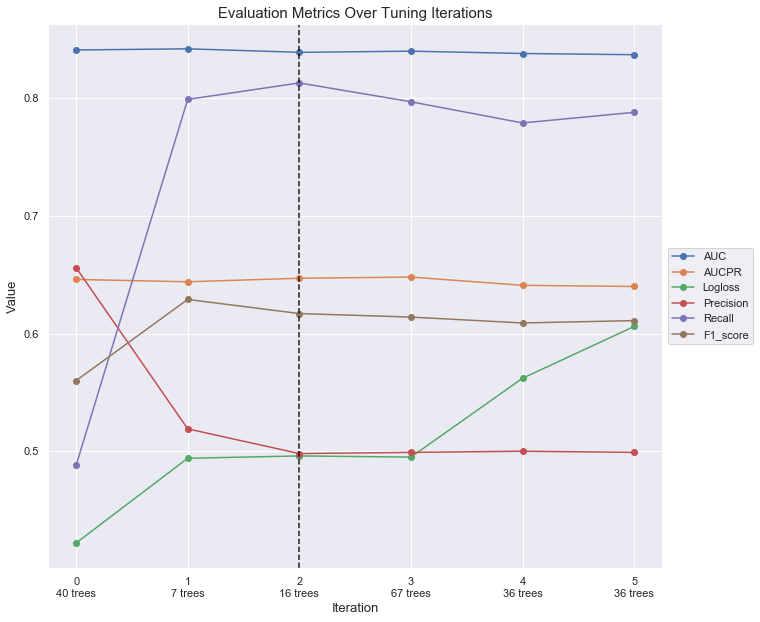

In [511]:
plt.figure(figsize=(11, 10));
N = 6
ind = np.arange(N)

# Plot metrics
for metric in list(df_iters.columns):
    plt.plot(ind, df_iters[metric].values, linewidth=1.5, marker='o', label=metric);

plt.axvline(x=2, color='k', linestyle='--')
    
# Set labels
plt.title('Evaluation Metrics Over Tuning Iterations', fontsize=15)
plt.ylabel('Value', fontsize=13)
plt.xlabel('Iteration', fontsize=13)
plt.xticks(
    np.arange(0, 6, 1),
    labels=['0\n40 trees', 
            '1\n7 trees',
            '2\n16 trees',
            '3\n67 trees',
            '4\n36 trees',
            '5\n36 trees'
           ]
)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

**Our model performs best at the second iteration.**
* Up to the second iteration, the imbalanced classes have been equalized and tree complexity was controlled to reduce overfitting.
* At this iteration, the model has:
    * Highest recall value with comparable precision and f1-scores at latter iterations. 
    * Lower logloss and tree count (boosting rounds) than latter iterations.
***

## 10. Final Model

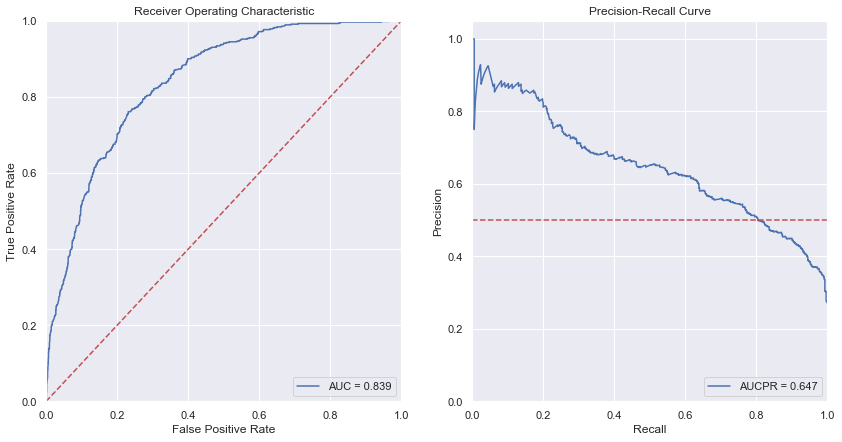

Best iteration at 16 rounds.
AUC:       0.839
AUCPR:     0.647
Logloss:   0.496
Precision: 0.498
Recall:    0.813
f1-score:  0.617


In [519]:
# Parameters at the end of this iteration
params = {
    'max_depth':        3,
    'min_child_weight': 13,
    'gamma':            5,
    'subsample':        1,        
    'colsample_bytree': 1,        
    'learning_rate':    0.3,      
    'n_estimators':     500,
    'scale_pos_weight': 2.76,        
    'verbosity':        0,
    'objective':        'binary:logistic',
    'eval_metric':      ['logloss', 'aucpr', 'auc'],     
    'seed':             42
}

# Instantiate classifier
clf_iter2 = xgb.XGBClassifier(**params)

# Fit classifier
fit_model(clf_iter2)

# Store eval metrics in a dict
evals_iter2 = clf_iter2.evals_result()

# Plot ROC and AUCPR
plot_roc_pr(clf_iter2)

# Print metrics
print('Best iteration at {} rounds.'.format(clf_iter2.best_iteration))
logloss_aucpr_auc(clf_iter2, evals_iter2)

# Make predictions
ypred_iter2 = clf_iter2.predict(X_test, ntree_limit=clf_iter2.best_ntree_limit)
class_metrics(y_test, ypred_iter2)

# 11. Additional Reference

In [14]:
# # For .train() instead of .fit()
# # main advantages of .train() method:
# # 1. can train with DMatrices - optimized for speed
# # 2. in the .train() method, you can set customized objective function
# #    and customized evaluation function
# # For .fit(), however, you can integrate with other 
# # scikit-learn APIs like pipelines - to impute, scale, etc.
# # (I was also getting a .01 higher AUC with .fit())

# # Load data into DMatrices (optimized for xgb algorithm)
# dtrain = xgb.DMatrix(X_train, label=y_train)
# dtest = xgb.DMatrix(X_test, label=y_test)

# # Define baseline parameters
# params_base = {
#     'verbosity': 0,
#     'objective': 'binary:logistic',
#     'eval_metric': 'auc',
#     'seed': 42
# }

# # Set number of boosting rounds
# num_round = 50

# # Specify validations set to watch performance
# watchlist = [(dtrain, 'train'), (dtest, 'eval')]

# # Initialize dictionary to store testing evaluation results
# bst1_evals = {}

# # Train model
# bst1 = xgb.train(
#     params=params_base,
#     dtrain=dtrain,
#     num_boost_round=num_round,
#     evals=watchlist,
#     maximize=True,
#     evals_result=bst1_evals,
#     early_stopping_rounds=10,
#     verbose_eval=0
# )

# # Make preditions (threshold of 0.5)
# # (This may not be the most effective way to make predictions)
# bst1_ypred = (bst1.predict(dtest, ntree_limit=bst1.best_ntree_limit) > 0.5).astype('int')

# # Plot the ROC Curve
# import matplotlib.pyplot as plt
# from sklearn import metrics
# bstpreds = bst1.predict(dtest)
# fpr, tpr, thresholds = metrics.roc_curve(y_test, bstpreds)
# roc_auc = metrics.auc(fpr, tpr)

# plt.title('Receiver Operating Characteristic')
# plt.plot(fpr, tpr, 'b', label = 'AUC = %0.6f' % roc_auc)
# plt.legend(loc = 'lower right')
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()

In [15]:
# from sklearn.feature_selection import SelectFromModel
# from numpy import sort

# thresholds = sort(clf_final.feature_importances_)
# for thresh in thresholds:
    
#     # Select features using threshold
#     selection = SelectFromModel(clf_final, threshold=thresh, prefit=True)
#     select_X_train = selection.transform(X_train)
    
#     # Train model
#     selection_model = xgb.XGBClassifier(**params)
#     selection_model.fit(select_X_train, y_train)
    
#     # Evaluate model
#     select_X_test = selection.transform(X_test)
#     ypred = selection_model.predict(select_X_test)
#     probs = selection_model.predict_proba(select_X_test)
#     preds = probs[:, 1]
    
#     print('Thresh:     {0:.3f}'.format(thresh))
#     print('# features: {}'.format(select_X_train.shape[1]))
#     print('AUC:        {0:.3f}'.format(roc_auc_score(y_test, preds)))
#     print('AUCPR:      {0:.3f}'.format(average_precision_score(y_test, preds)))
#     print('Precision:  {0:.3f}'.format(precision_score(y_test, ypred)))
#     print('Recall:     {0:.3f}'.format(recall_score(y_test, ypred)))
#     print('f1-score:   {0:.3f}'.format(f1_score(y_test, ypred)))
#     print('------------------')